## notebook to simulate the cell fates upon in silico KO

- last updated: 03/11/2024
- author: Yang-Joon Kim

- 1) We will use the cell-cell transition probabilities from the CellOracle - for both WT and in silico KO cases.
- 2) Using Markovian simulation, we will compute the fraction of cell types among the "terminal states" - CellRank2 (?)
- 3) We will repeat the above procedure for all genes
- 4) (Optional) How do we incoporate the "real-time" component in here?


- The first part of this notebook is based off of the following notebook:
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/05_simulation/misc/Analyze_transition_probability_with_Paul_etal_2015_data.ipynb

In [16]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [1]:
import celloracle as co
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.14.0'

In [3]:
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [9,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

### 1. load the celloracle data



In [5]:
# load the Oracle object 
oracle = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/sequencing_ver1/TDR118_cicero_output/06_TDR118.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 13022
    n_genes: 3000
    cluster_name: predicted.id
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 12674 genes
    n_regulatory_in_TFdict: 863 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 316 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1637 genes
    k_for_knn_imputation: 325
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [6]:
# load the Oracle object (post in silico KO simulation)
oracle = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/sequencing_ver1/TDR118_cicero_output/13_TDR118_pseudotime_KOsimulated.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 13022
    n_genes: 3000
    cluster_name: predicted.id
    dimensional_reduction_name: X_atac.umap.cellranger
    n_target_genes_in_TFdict: 12674 genes
    n_regulatory_in_TFdict: 863 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 316 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1637 genes
    k_for_knn_imputation: 325
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Done

In [9]:
# load the Links object (inferred GRNs)
links = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/sequencing_ver1/TDR118_cicero_output/08_TDR118_celltype_GRNs.celloracle.links")
links

### 2. Make predictive models for simulation

In [10]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

  0%|          | 0/14 [00:00<?, ?it/s]

### 3. in silico perturbation simulation



#### 3.1. check gene expression pattern (imputed_count)

In [19]:
oracle.adata

AnnData object with n_obs × n_vars = 13022 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_annotation', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'Lineage_Meso', 'Lineage_NeuroEcto', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto', 'Pseudotime'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'hvg', 'predicted.id_colors', 'log1p'
    obsm: 'X_atac.umap', 'X_atac.umap.cellranger', 'X_umap', 'X_umap.pca30', 'X_wnn.umap'
    layers: 'raw_count', 'normalized_count', 'imputed_count', 'simulation_input',

In [20]:
oracle.cluster_column_name

'predicted.id'

In [25]:
# # Check gene expression 
# goi = "meox1"
# sc.pl.draw_graph(oracle.adata, color=[goi, "predicted.id"],
#                  layer="imputed_count", use_raw=False, cmap="viridis")

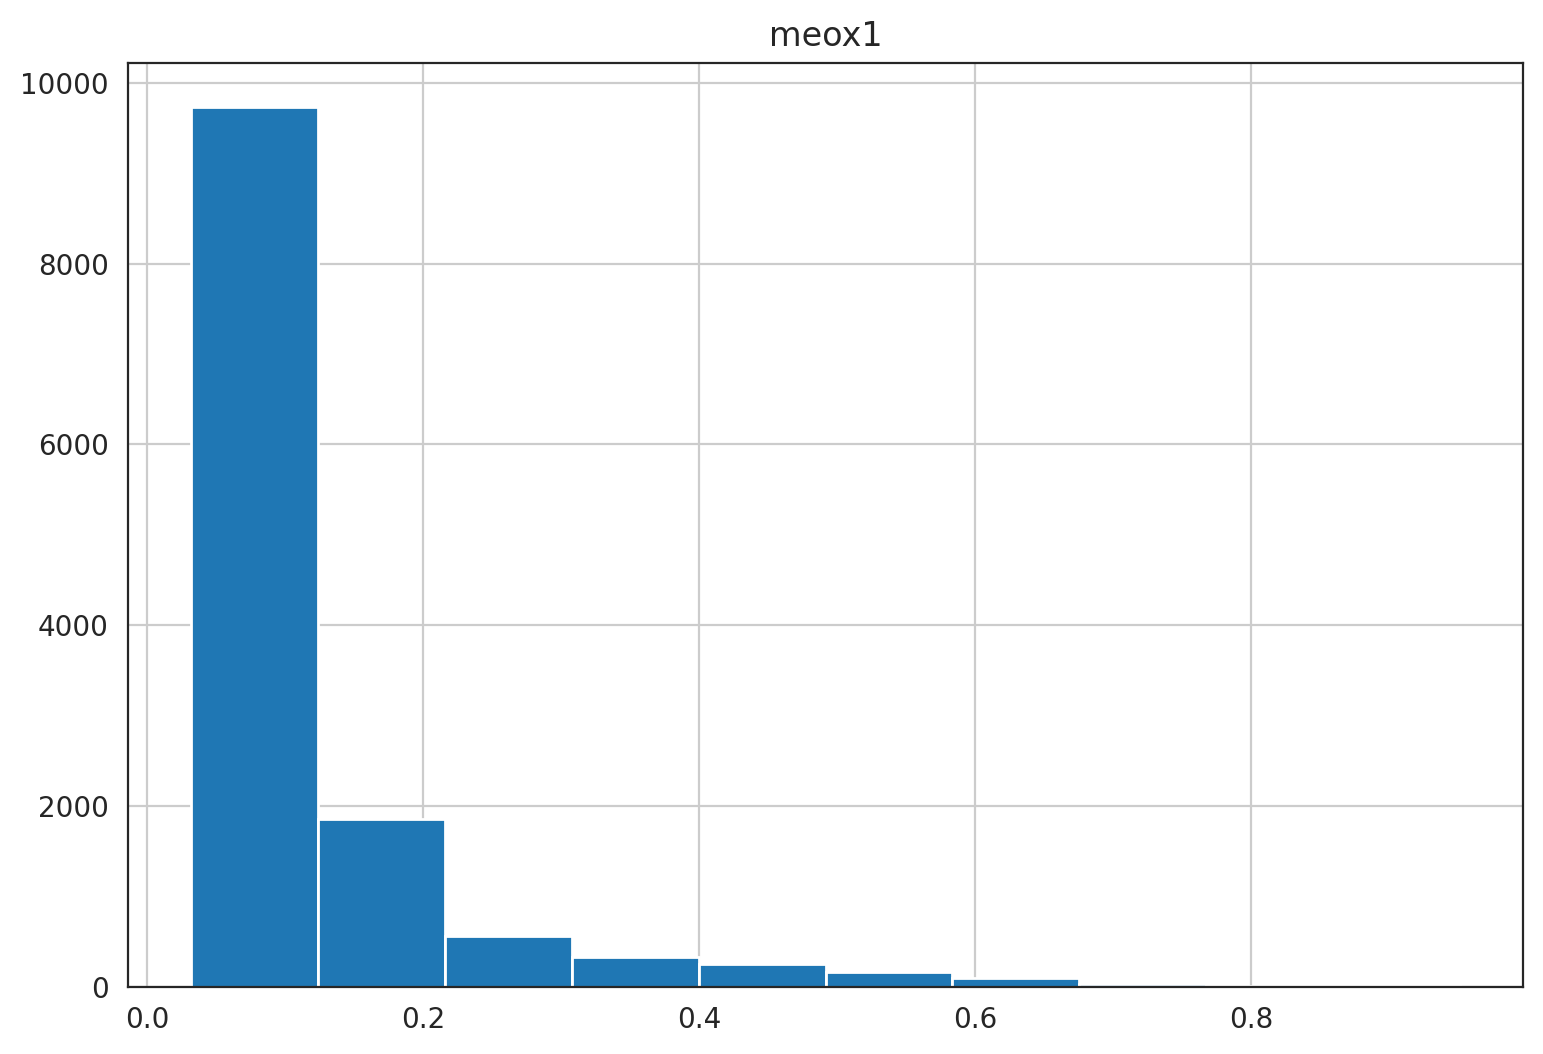

In [24]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

#### 3.2. calcualte future gene expression after perturbation

In [26]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

#### 3.3. calculate transition probability between cells

In the step above, we simulated simulated future gene expression values after perturbation. This prediction is based on itelative calculations of signal propagations within the GRN.

Next step, we will calculate the probabilityof a cell state transition based on the simulated data. Using the transition probability between cells, we can predict how a cell changes after perturbation.

This transition probability will be used in two ways.

(1) Visualization of directed trjectory graph.

(2) Markof simulation.

In Step 4.2 and 4.3, we usefunctions imported from the velocytoloom class in velocyto.py. Please see the documentation of VelocytoLoom for more information. http://velocyto.org/velocyto.py/fullapi/api_analysis.html

In [27]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)

#### 3.4. extract transition probability data

In [28]:
def extract_transition_probability(oracle_object):
    # Cell name
    cell_name = oracle.adata.obs.index
    
    # Get probability as numpy matrix
    transition_prob = oracle.transition_prob
    
    # Convert probability into data frame.
    df_transition_prob = pd.DataFrame(transition_prob, index=cell_name, columns=cell_name)
    df_transition_prob = df_transition_prob.rename_axis(index="From", columns="To")
    
    return df_transition_prob

In [29]:
df_transition_prob = extract_transition_probability(oracle)

In [30]:
df_transition_prob

To                  AAACAGCCACCTAAGC-1  AAACAGCCAGGGAGGA-1  \
From                                                         
AAACAGCCACCTAAGC-1                 0.0                 0.0   
AAACAGCCAGGGAGGA-1                 0.0                 0.0   
AAACAGCCATAGACCC-1                 0.0                 0.0   
AAACATGCAAACTCAT-1                 0.0                 0.0   
AAACATGCAAGGACCA-1                 0.0                 0.0   
...                                ...                 ...   
TTTGTTGGTCGACTCC-1                 0.0                 0.0   
TTTGTTGGTGATTTGG-1                 0.0                 0.0   
TTTGTTGGTTCACCCA-1                 0.0                 0.0   
TTTGTTGGTTCGGGAT-1                 0.0                 0.0   
TTTGTTGGTTTGTGGA-1                 0.0                 0.0   

To                  AAACAGCCATAGACCC-1  AAACATGCAAACTCAT-1  \
From                                                         
AAACAGCCACCTAAGC-1                 0.0                 0.0   
AAACAGCCAGGGAGGA-1                 0.0                 0.0   
AAACAGCCATAGACCC-1                 0.0                 0.0   
AAACATGCAAACTCAT-1                 0.0                 0.0   
AAACATGCAAGGACCA-1                 0.0                 0.0   
...                                ...                 ...   
TTTGTTGGTCGACTCC-1                 0.0                 0.0   
TTTGTTGGTGATTTGG-1                 0.0                 0.0   
TTTGTTGGTTCACCCA-1                 0.0                 0.0   
TTTGTTGGTTCGGGAT-1                 0.0                 0.0   
TTTGTTGGTTTGTGGA-1                 0.0                 0.0   

To                  AAACATGCAAGGACCA-1  AAACATGCAAGGATTA-1  \
From                                                         
AAACAGCCACCTAAGC-1                 0.0                 0.0   
AAACAGCCAGGGAGGA-1                 0.0                 0.0   
AAACAGCCATAGACCC-1                 0.0                 0.0   
AAACATGCAAACTCAT-1                 0.0                 0.0   
AAACATGCAAGGACCA-1                 0.0                 0.0   
...                                ...                 ...   
TTTGTTGGTCGACTCC-1                 0.0                 0.0   
TTTGTTGGTGATTTGG-1                 0.0                 0.0   
TTTGTTGGTTCACCCA-1                 0.0                 0.0   
TTTGTTGGTTCGGGAT-1                 0.0                 0.0   
TTTGTTGGTTTGTGGA-1                 0.0                 0.0   

To                  AAACATGCACGTTACA-1  AAACATGCAGGACCTT-1  \
From                                                         
AAACAGCCACCTAAGC-1            0.000000                 0.0   
AAACAGCCAGGGAGGA-1            0.000000                 0.0   
AAACAGCCATAGACCC-1            0.000000                 0.0   
AAACATGCAAACTCAT-1            0.000000                 0.0   
AAACATGCAAGGACCA-1            0.000000                 0.0   
...                                ...                 ...   
TTTGTTGGTCGACTCC-1            0.000136                 0.0   
TTTGTTGGTGATTTGG-1            0.000000                 0.0   
TTTGTTGGTTCACCCA-1            0.000000                 0.0   
TTTGTTGGTTCGGGAT-1            0.000000                 0.0   
TTTGTTGGTTTGTGGA-1            0.000000                 0.0   

To                  AAACATGCAGGCGATA-1  AAACATGCAGTTTCTC-1  ...  \
From                                                        ...   
AAACAGCCACCTAAGC-1            0.000000                 0.0  ...   
AAACAGCCAGGGAGGA-1            0.000000                 0.0  ...   
AAACAGCCATAGACCC-1            0.000000                 0.0  ...   
AAACATGCAAACTCAT-1            0.000000                 0.0  ...   
AAACATGCAAGGACCA-1            0.000000                 0.0  ...   
...                                ...                 ...  ...   
TTTGTTGGTCGACTCC-1            0.000000                 0.0  ...   
TTTGTTGGTGATTTGG-1            0.000000                 0.0  ...   
TTTGTTGGTTCACCCA-1            0.001043                 0.0  ...   
TTTGTTGGTTCGGGAT-1            0.000

In [37]:
NMPs = oracle.adata[oracle.adata.obs["predicted.id"]=="NMPs"]
NMPs

View of AnnData object with n_obs × n_vars = 103 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_annotation', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'Lineage_Meso', 'Lineage_NeuroEcto', 'Pseudotime_Lineage_Meso', 'Pseudotime_Lineage_NeuroEcto', 'Pseudotime'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'hvg', 'predicted.id_colors', 'log1p'
    obsm: 'X_atac.umap', 'X_atac.umap.cellranger', 'X_umap', 'X_umap.pca30', 'X_wnn.umap'
    layers: 'raw_count', 'normalized_count', 'imputed_count', 'simulation_i

In [ ]:
# # choose one of the NMP cells
# cell_names = "AAATGGCCAATGAAGC-1"

In [42]:
# Let's pick up one cell to visuazlize transition probability. 
# cell_name = np.random.choice(oracle.adata.obs.index, 1)[0]
cell_name = np.random.choice(NMPs.obs.index, 1)[0]

print("Selected cell_name is ", cell_name)

Selected cell_name is  GGAAACTCAGCTTACA-1


In [43]:
# Pickup transition probabilities of the cell of interest
tp = df_transition_prob.loc[cell_name, :]

#### visualize the transition probability of selected cell

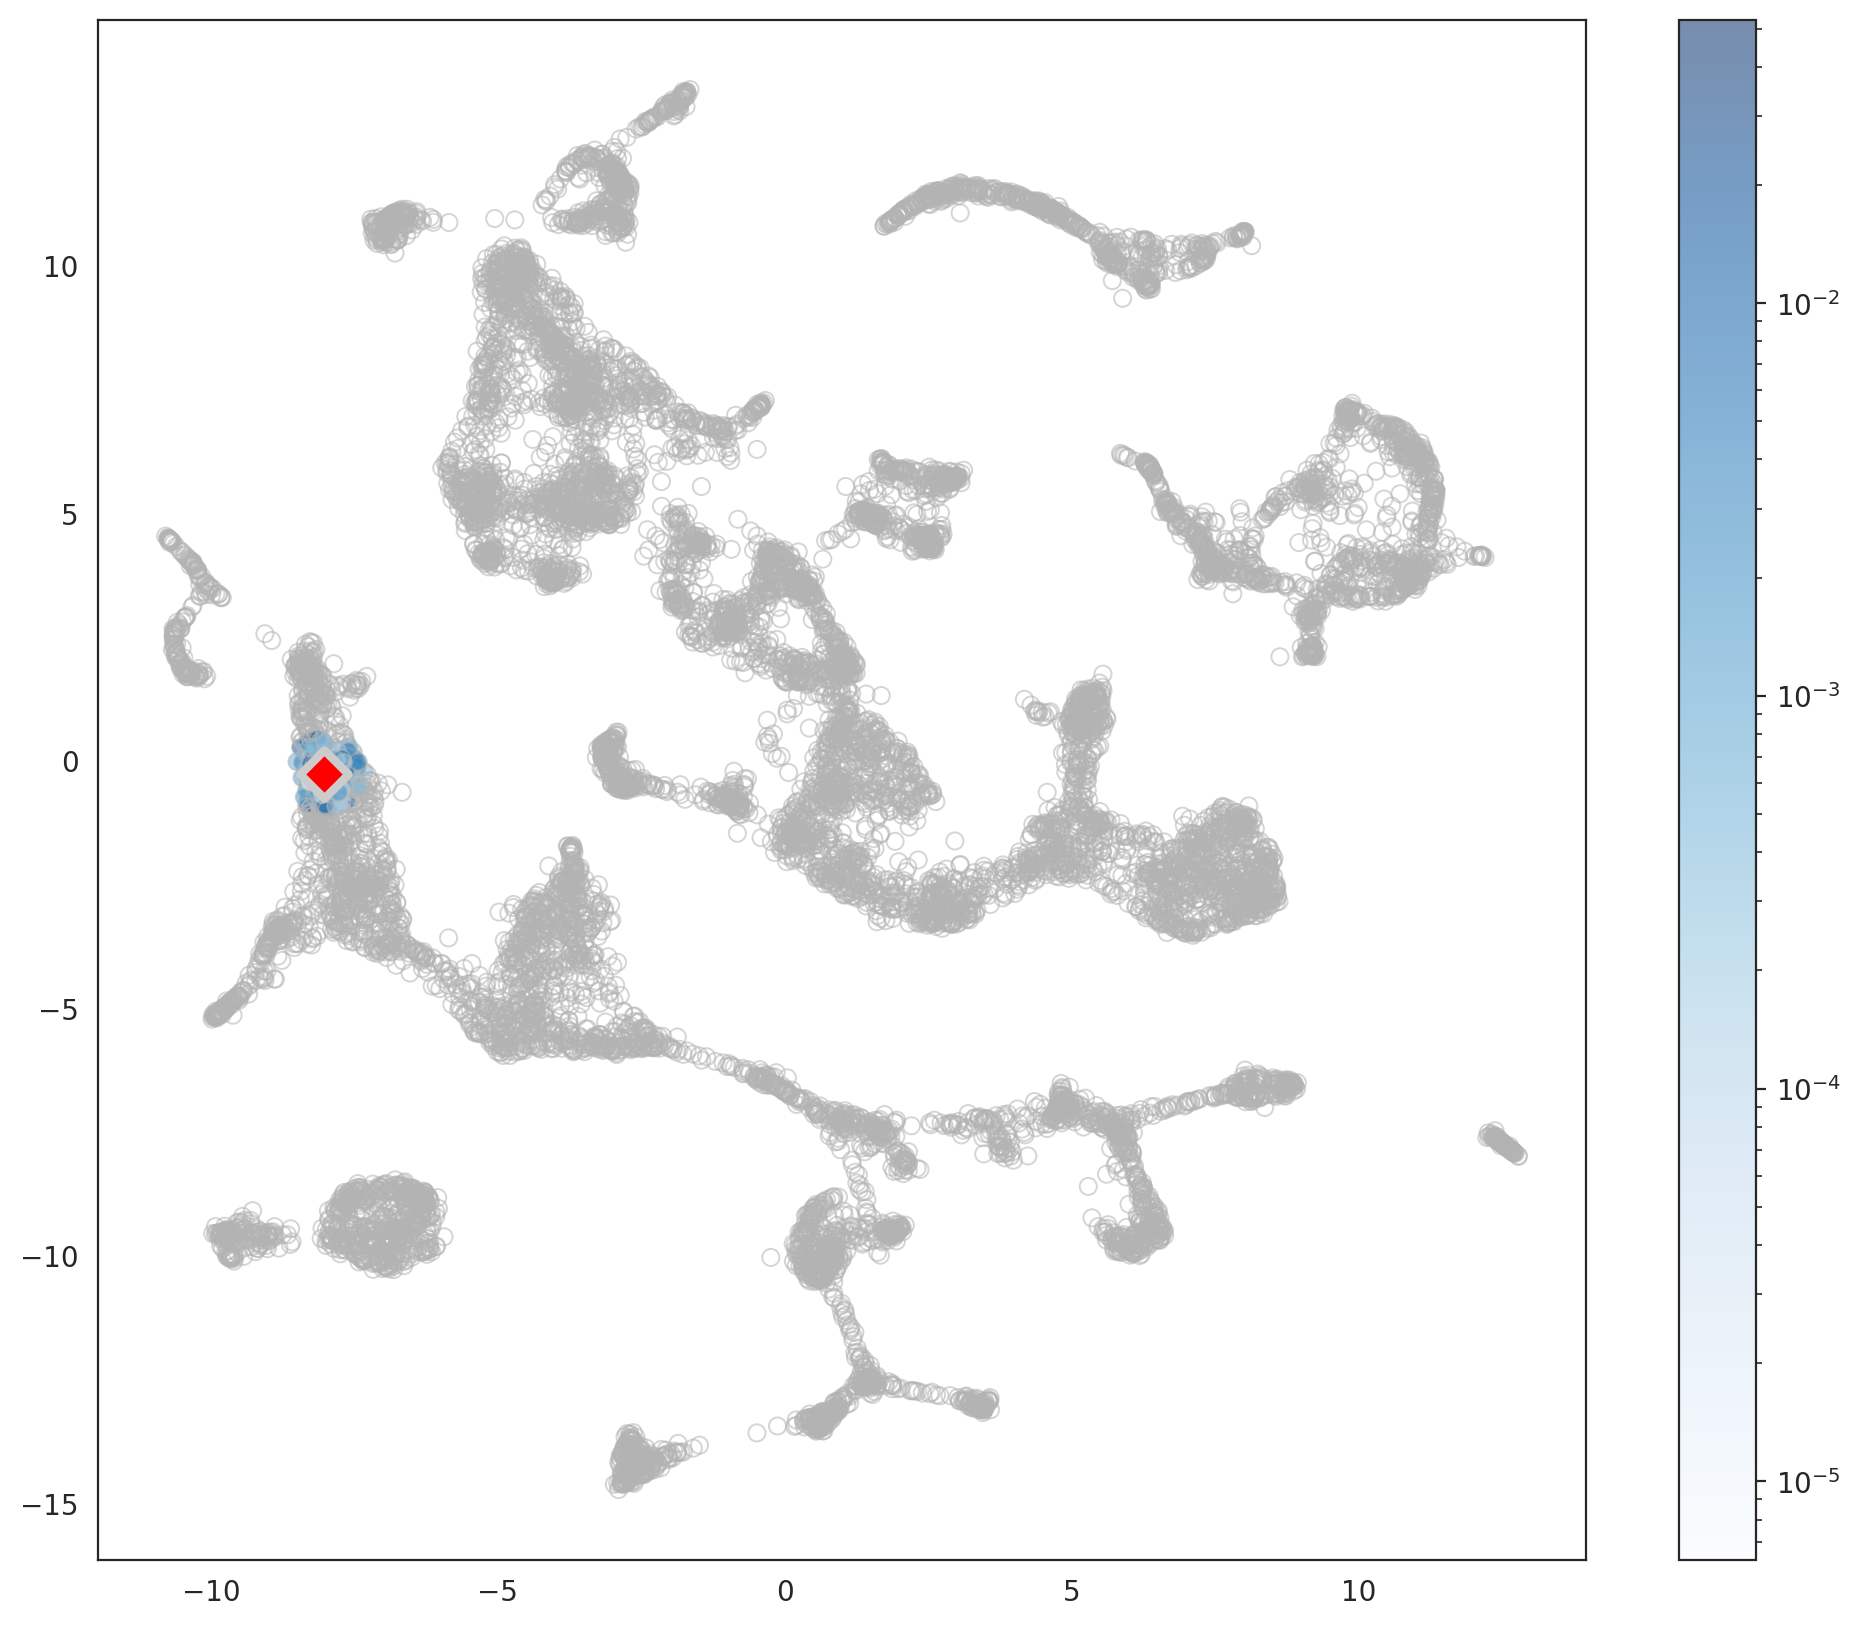

In [44]:
import matplotlib.colors as colors

fig = plt.figure(figsize=[12, 10])


# Show transition probability
ax = plt.scatter(oracle.embedding[:, 0], # x
                 oracle.embedding[:, 1], # y
                 c=tp, # Show transition probability as color
                 norm=colors.LogNorm(),
                 cmap="Blues", lw=0.7, s=38, alpha=0.55,  
                 edgecolor="0.7", rasterized=True)


# Show the cell we picked up.
ix = np.where(oracle.adata.obs.index == cell_name)[0][0]
plt.scatter(oracle.embedding[ix, 0], oracle.embedding[ix, 1],
            c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")

# Show colorbar
plt.colorbar(ax)
plt.show()

Selected cell_name is  GGAAACTCAGCTTACA-1


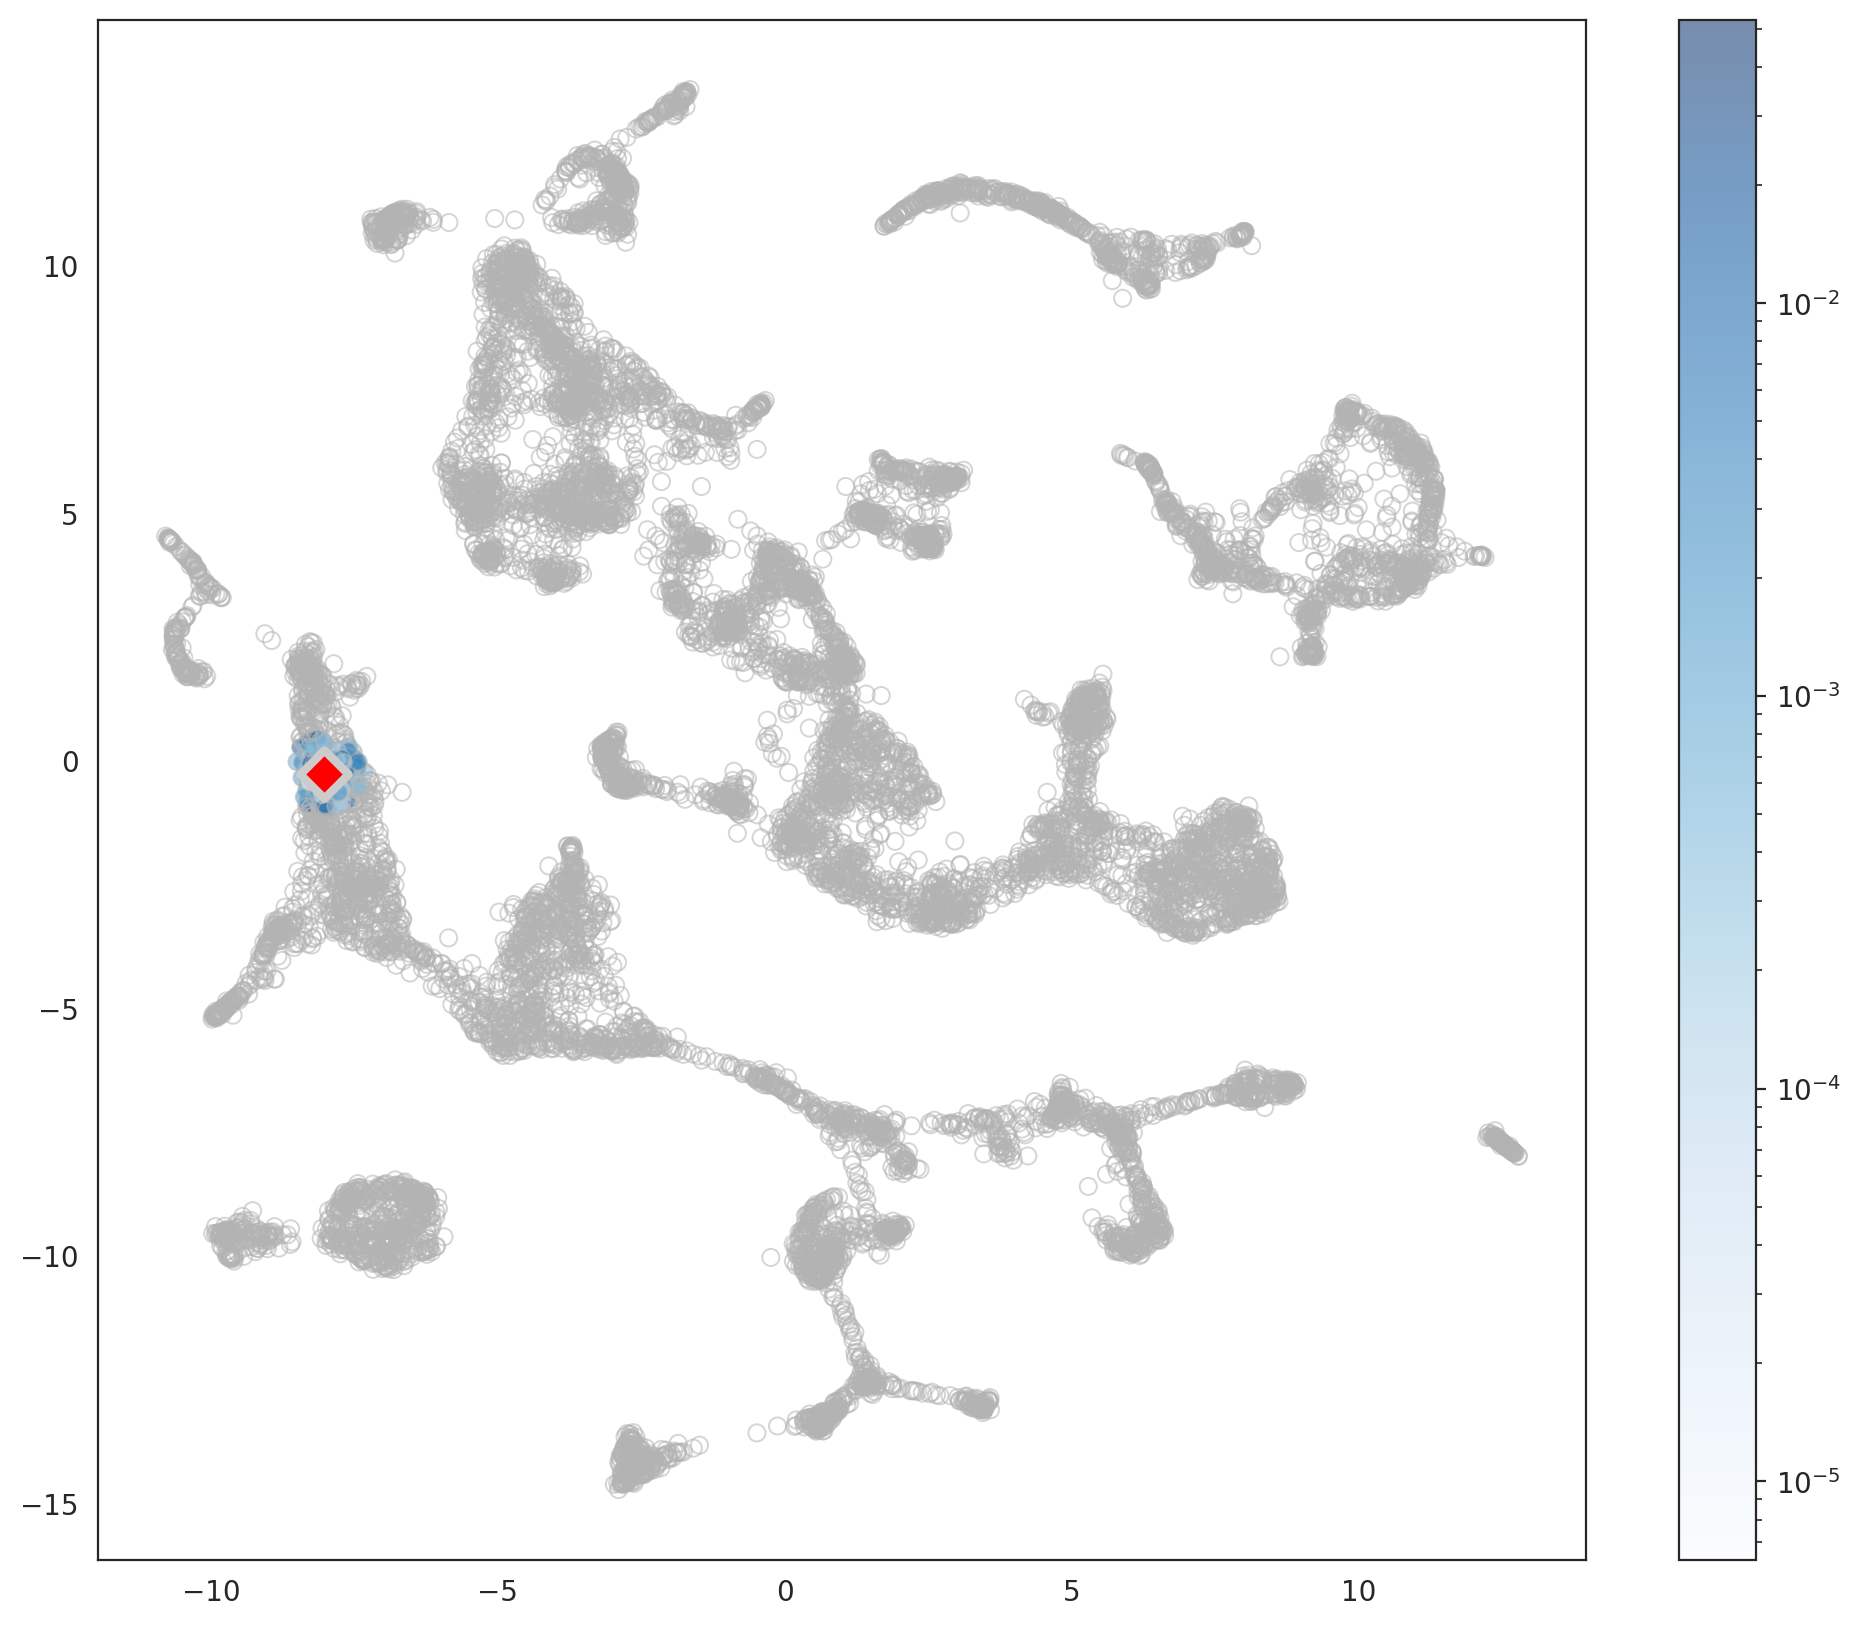

Selected cell_name is  TGCAGGCTCTCACTCA-1


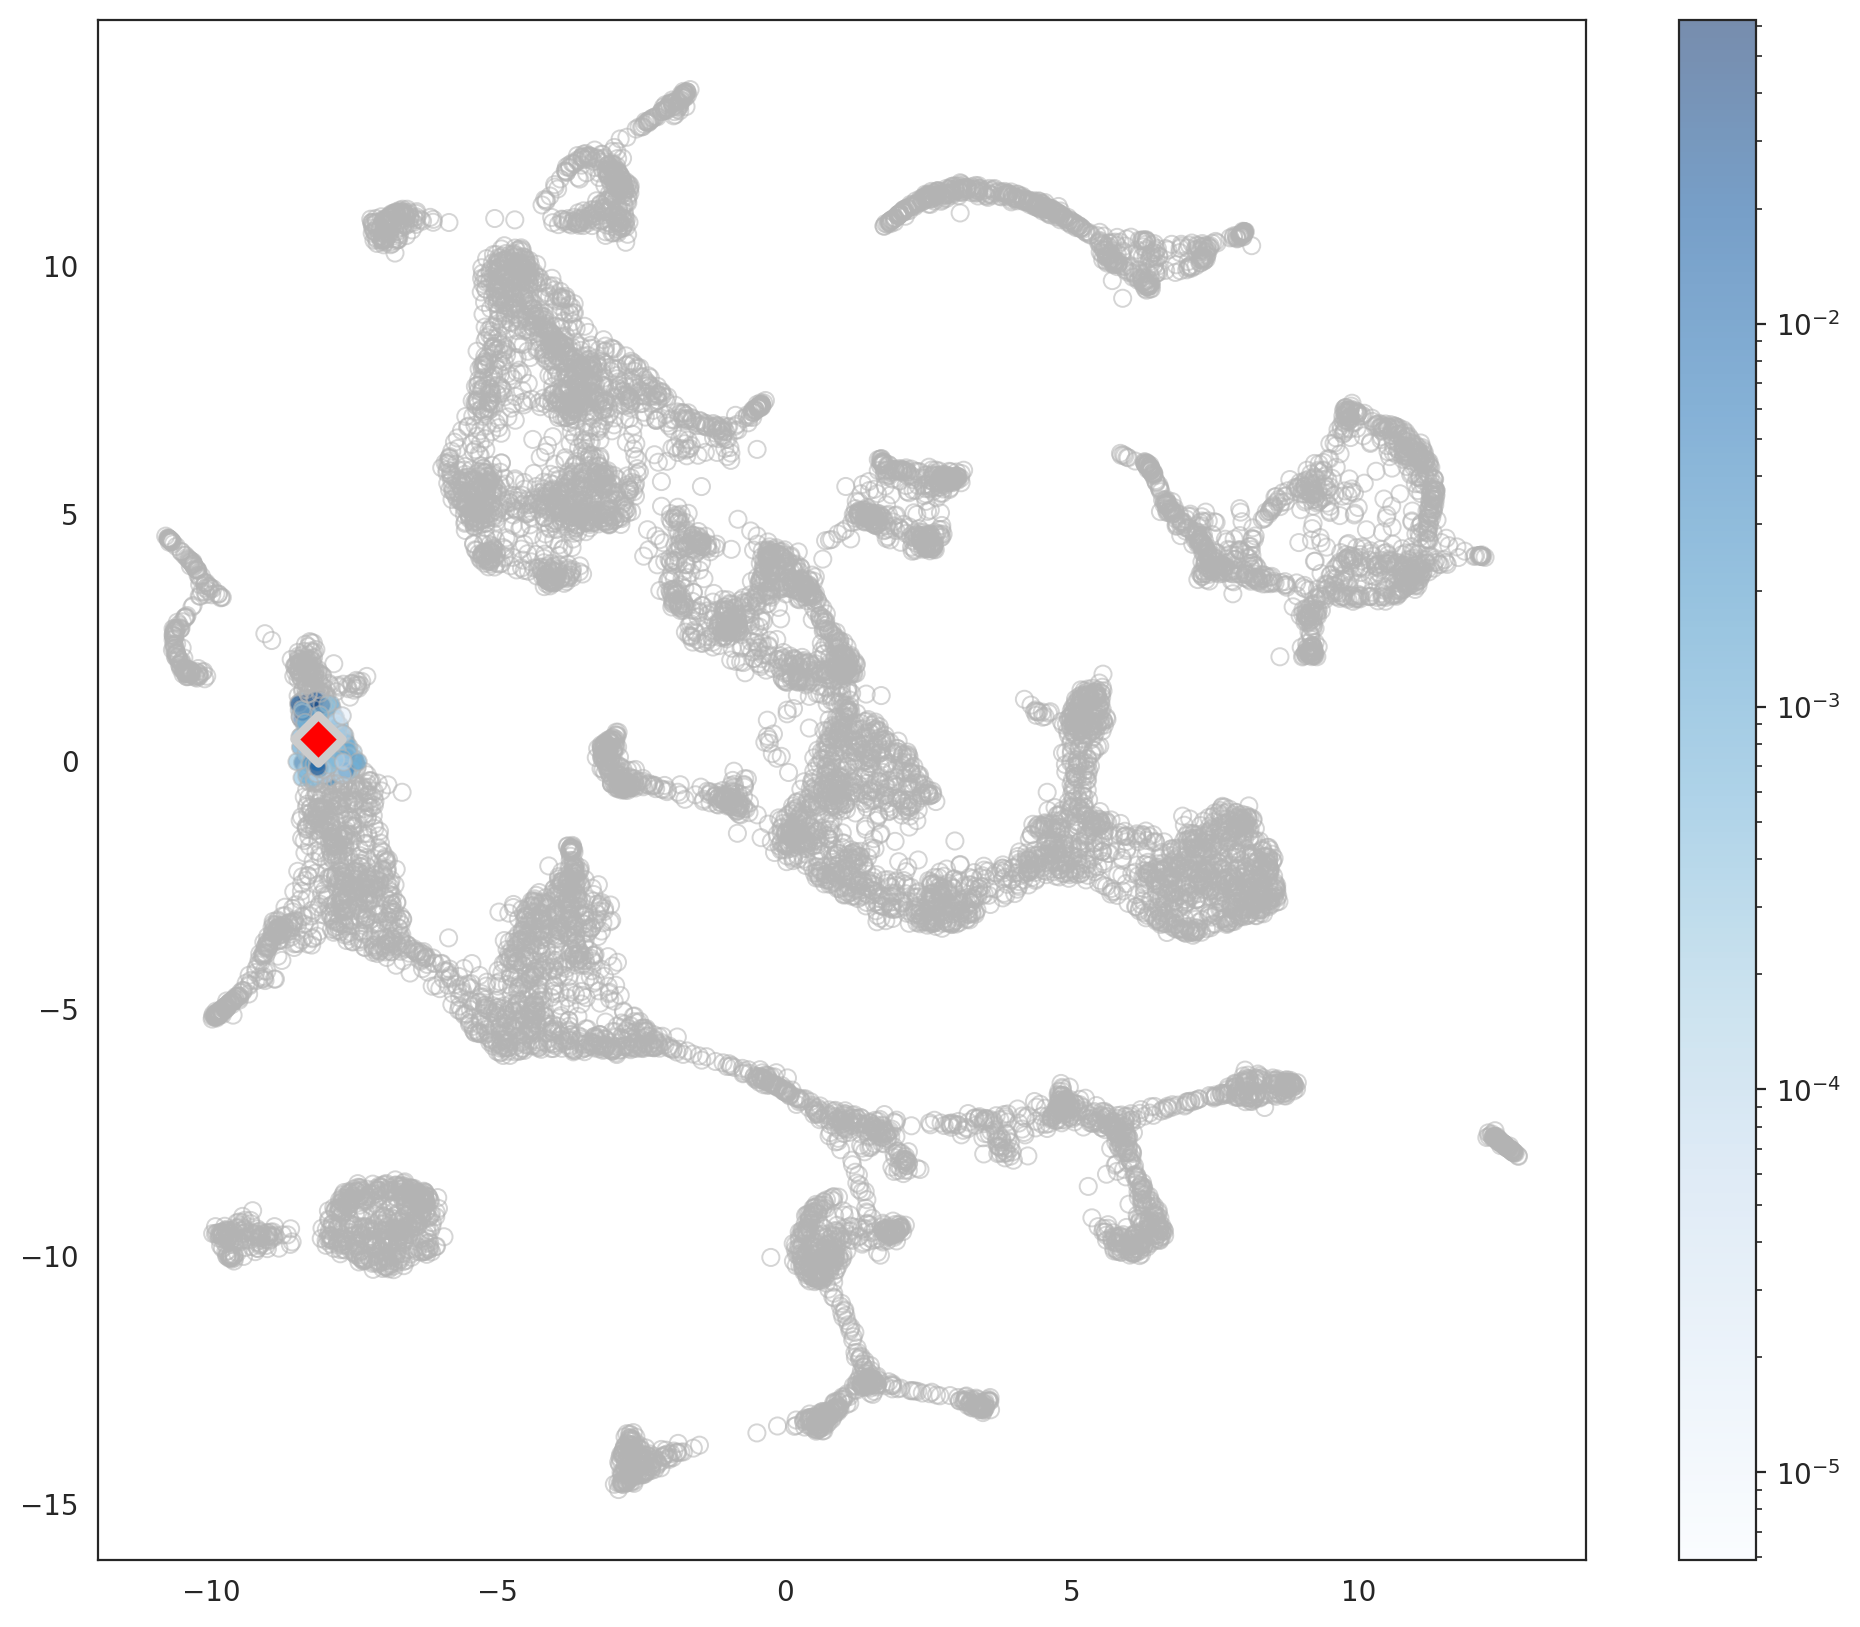

Selected cell_name is  TGTGGCCAGTCAATTG-1


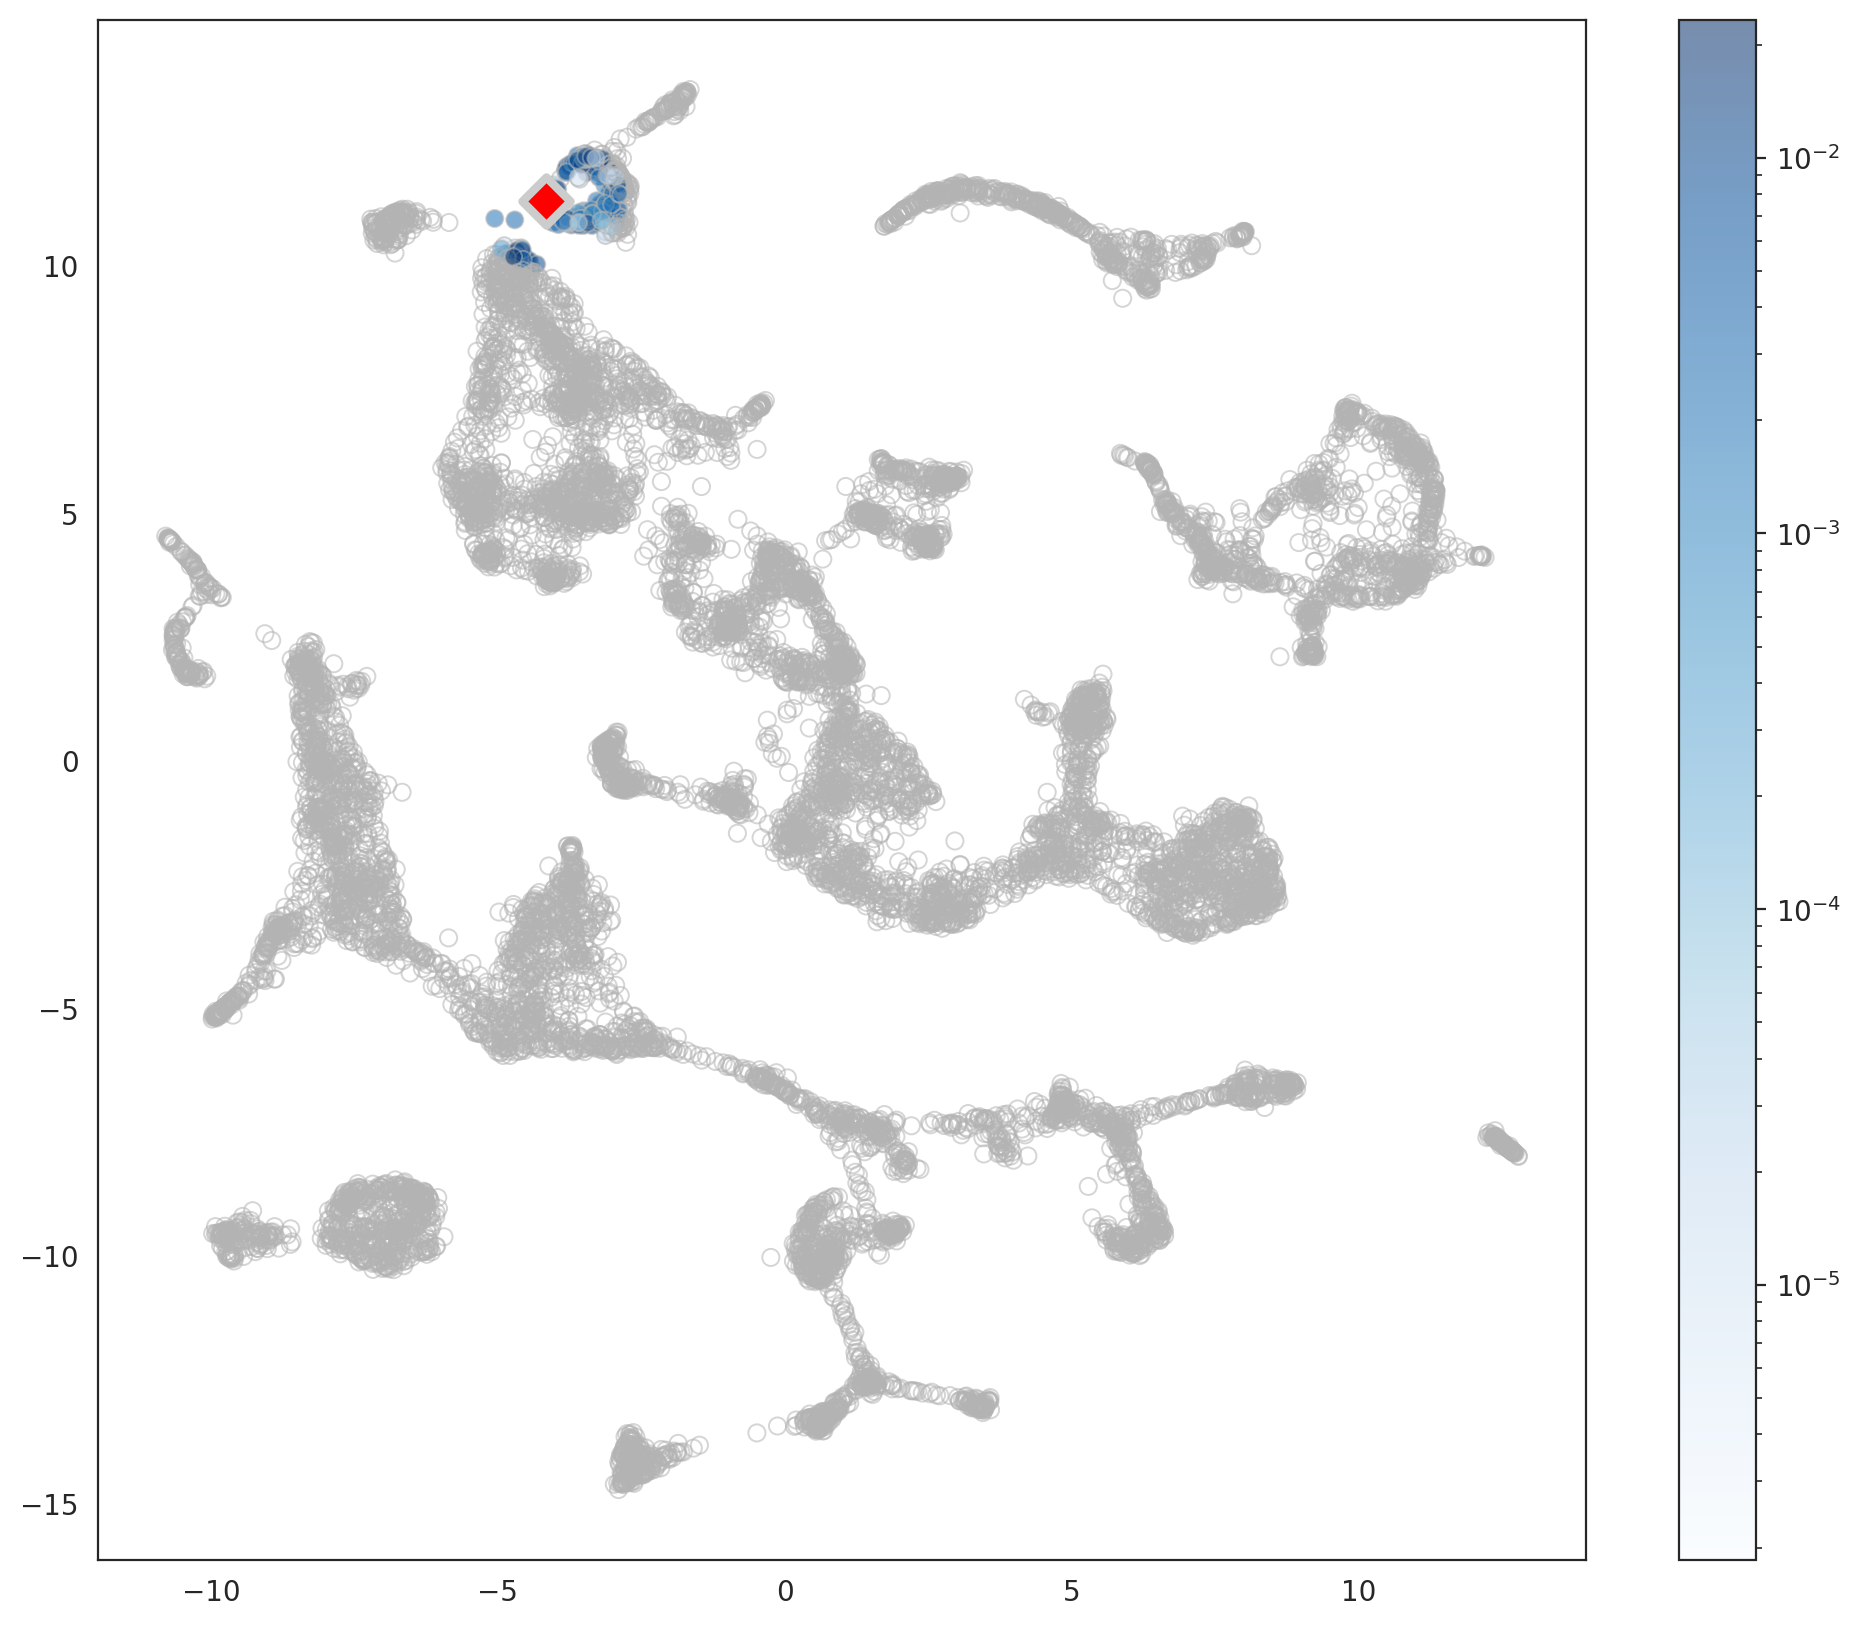

Selected cell_name is  TTTCCGGGTTGGCCGA-1


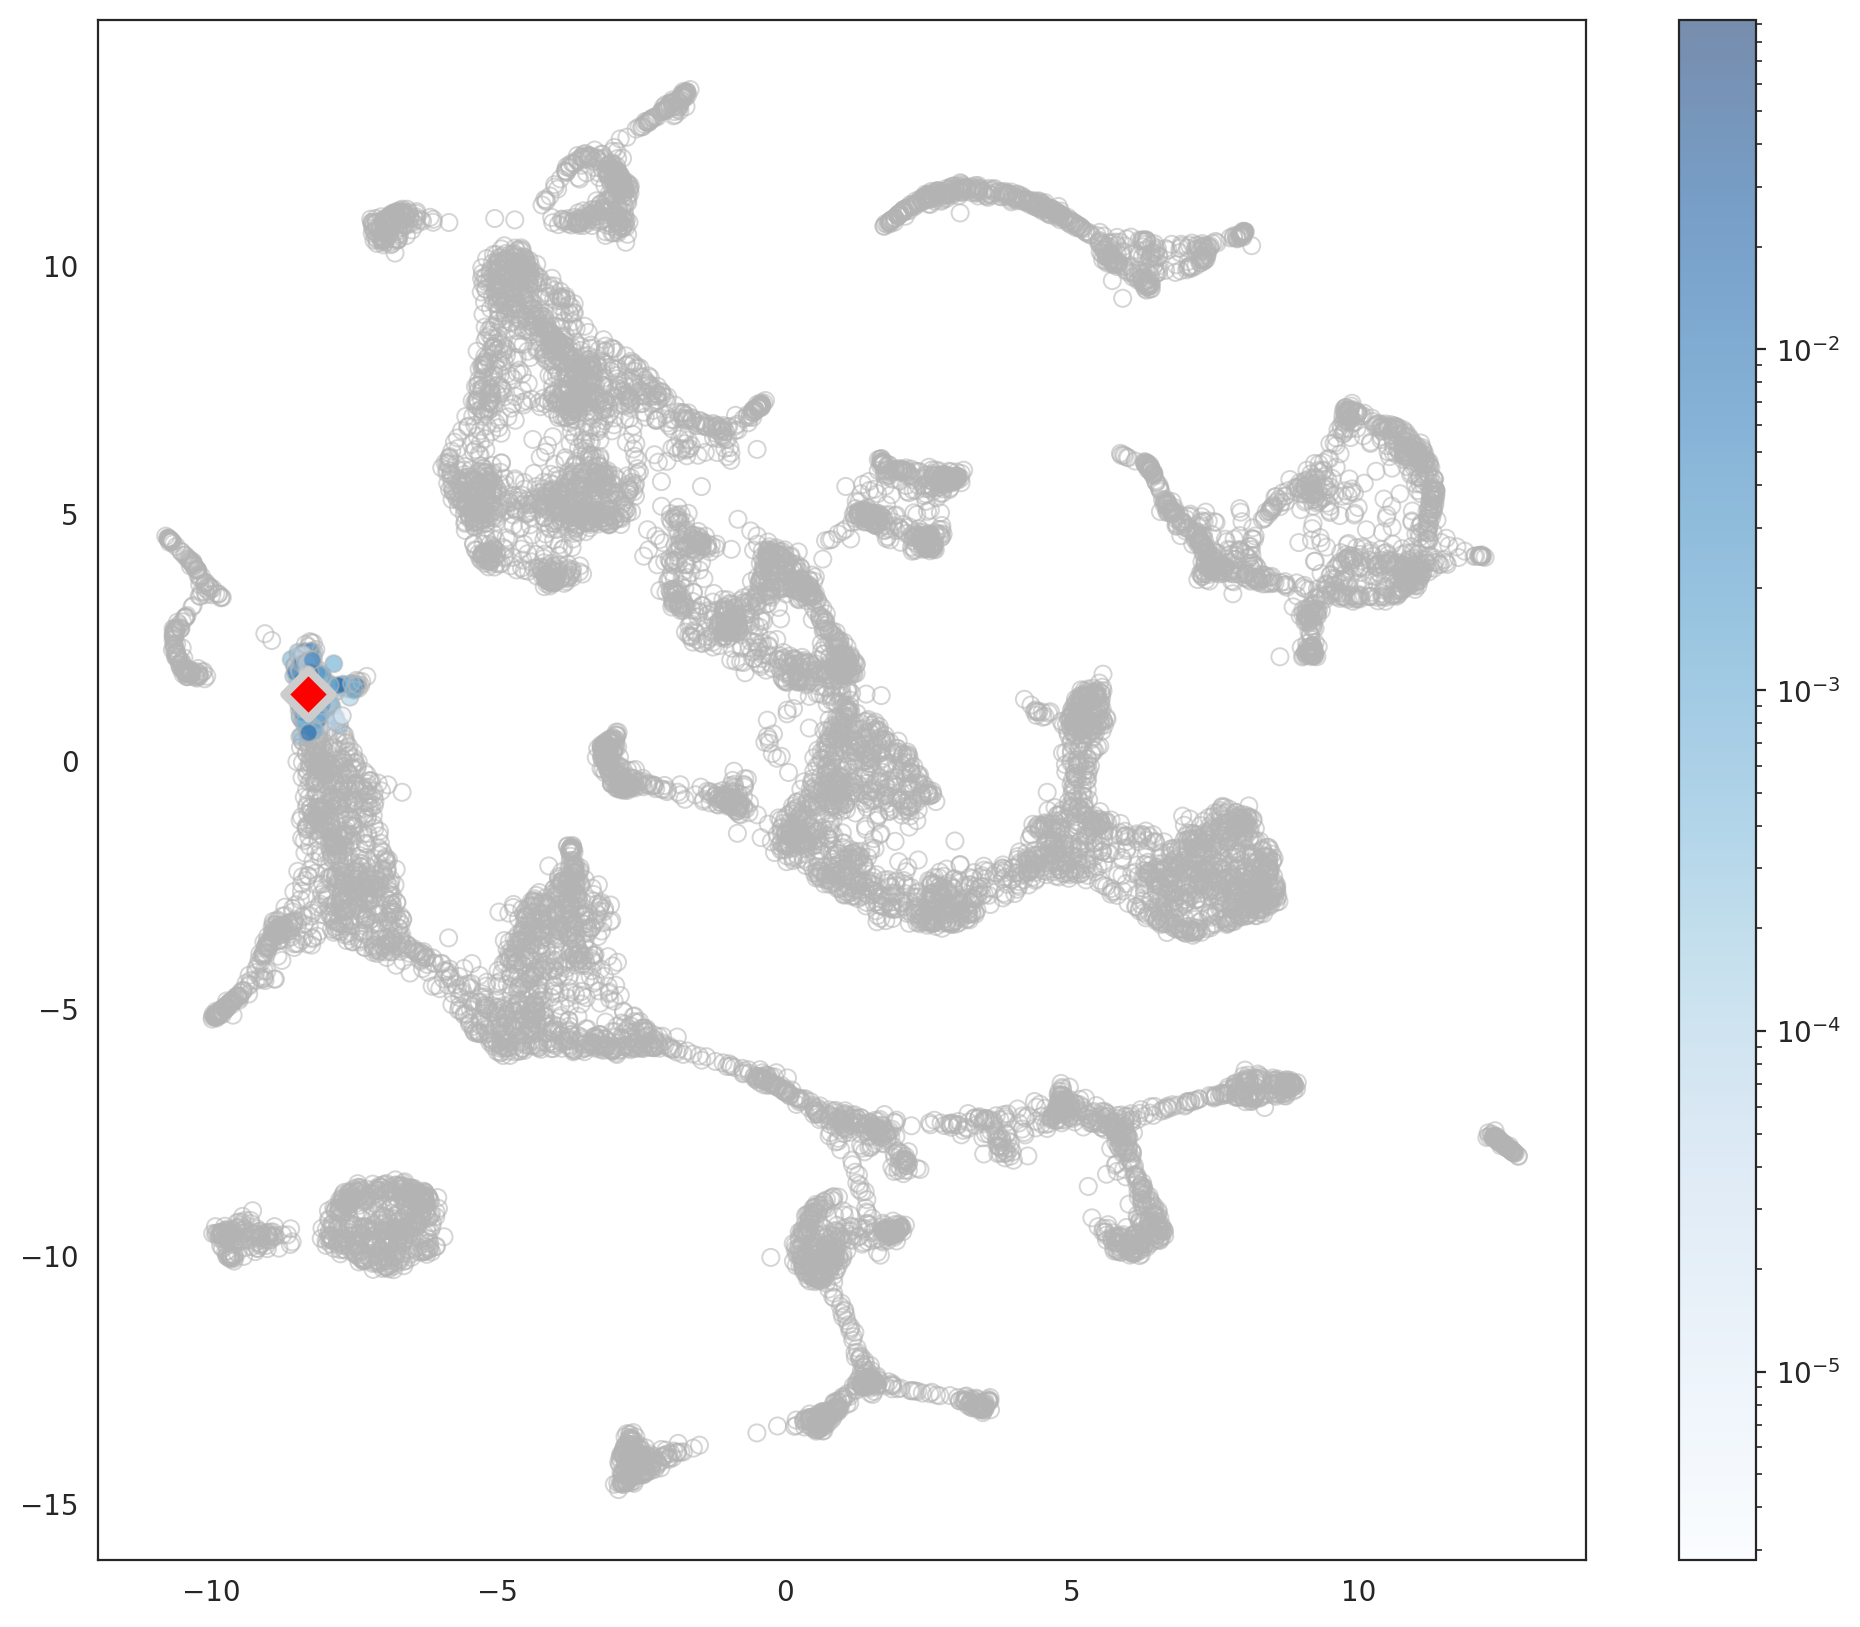

Selected cell_name is  ATGCATTCACAATACT-1


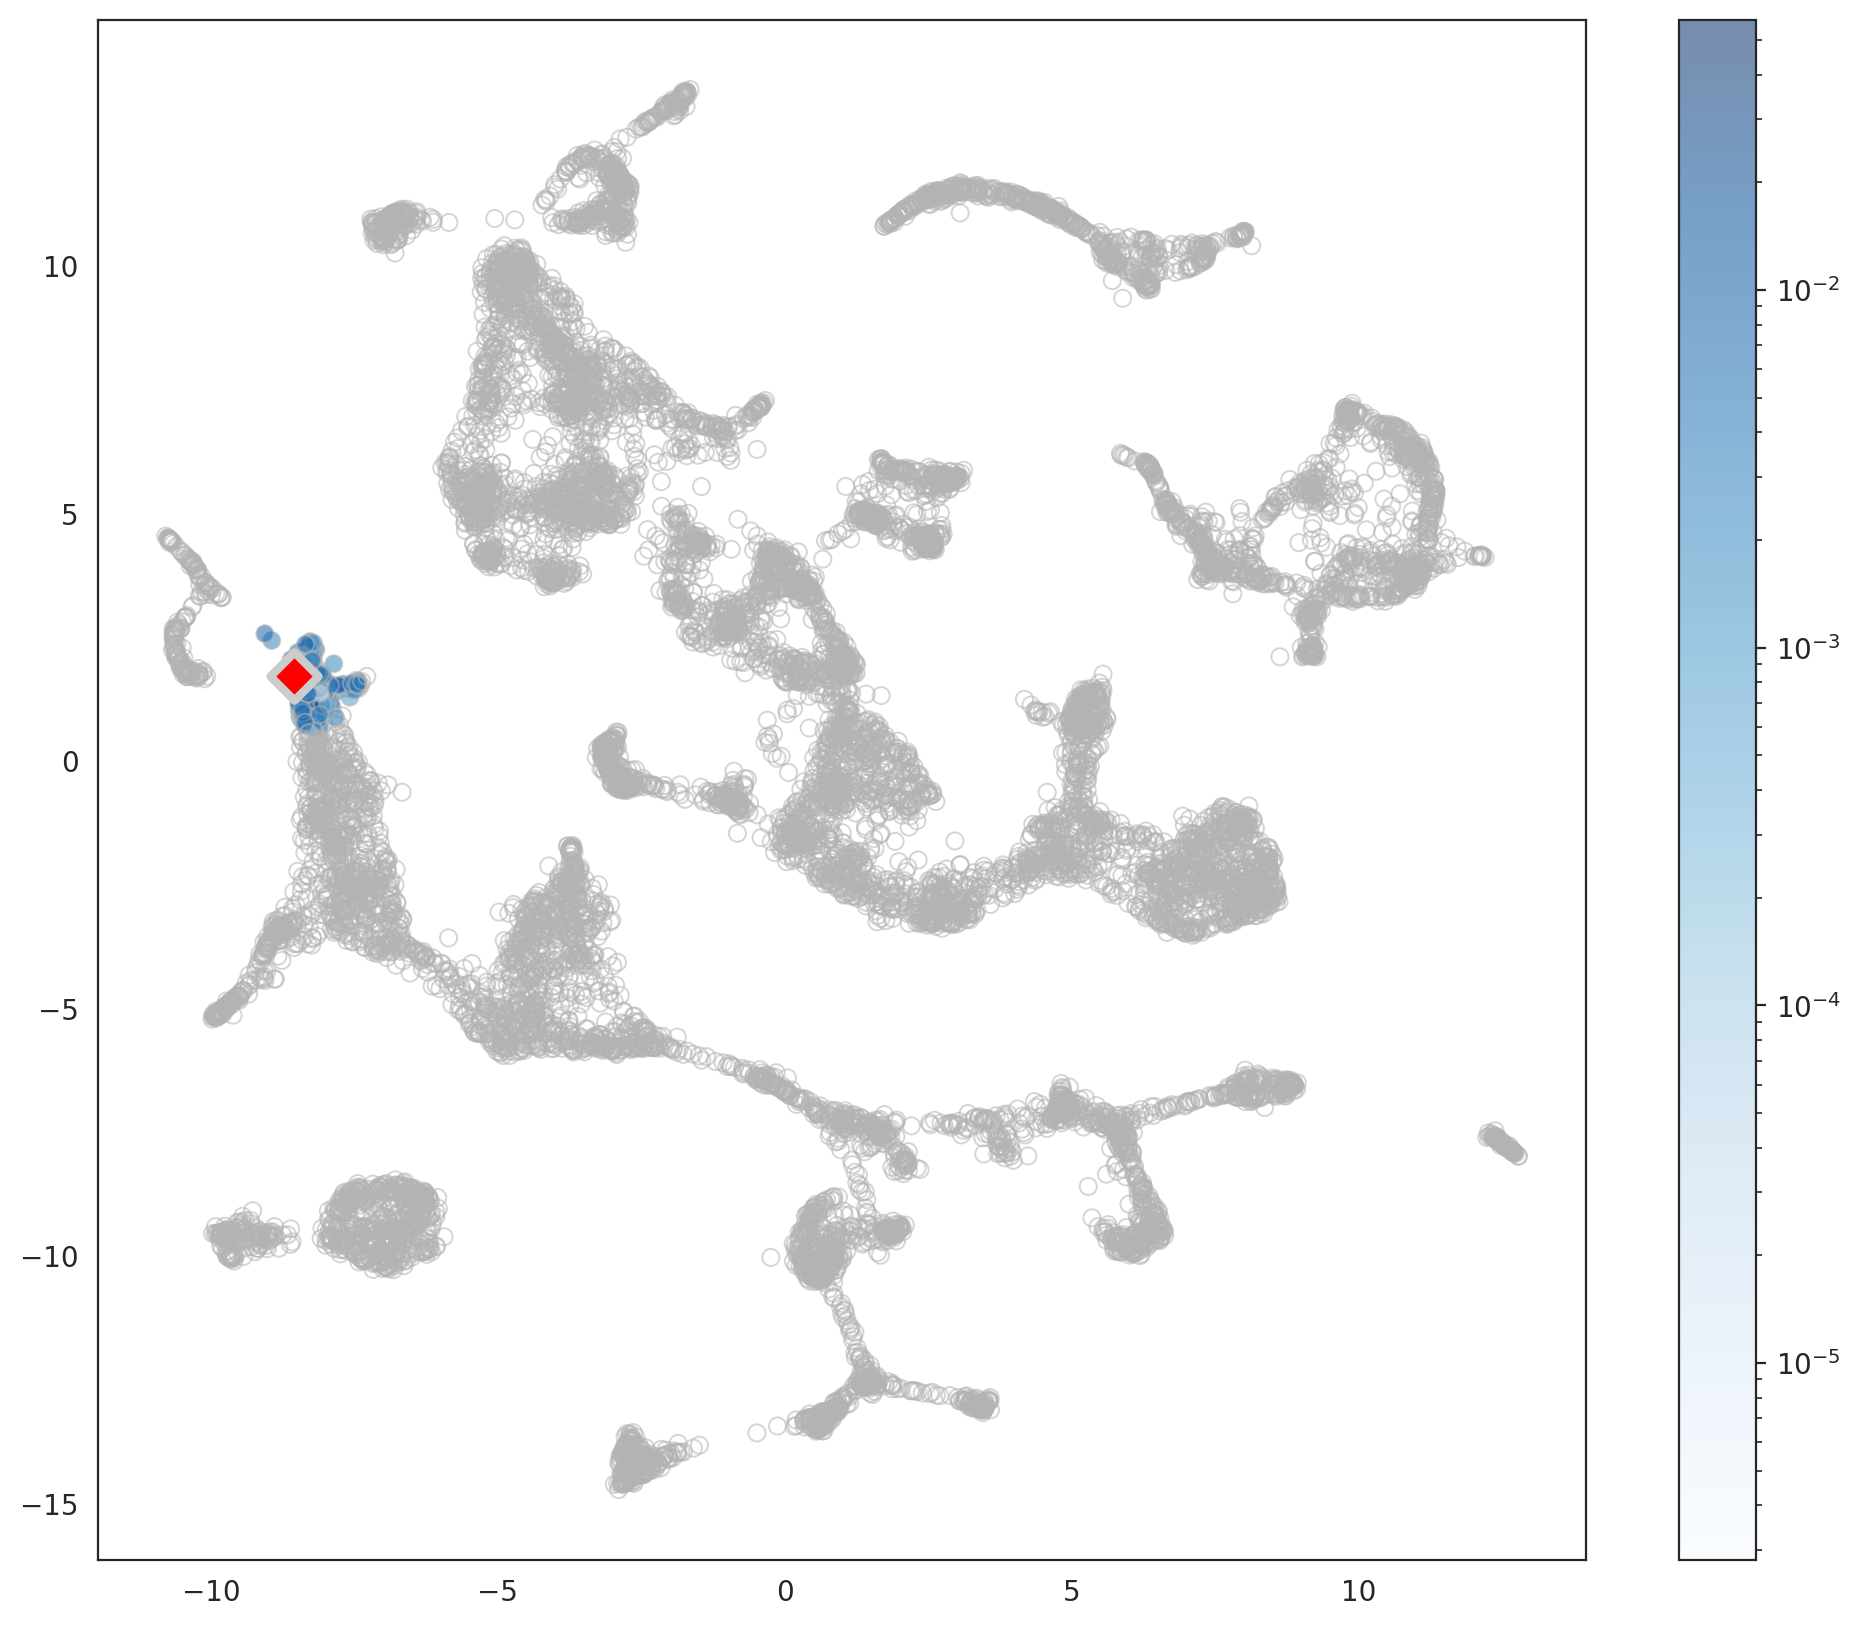

In [45]:
# Let's randomly pick up cells and show transition probability.

np.random.seed(123)
for i in range(5):
    
    # Let's pick up one cell to visuazlize transition probability. 
    cell_name = np.random.choice(NMPs.obs.index, 1)[0]

    print("Selected cell_name is ", cell_name)
    
    # Pickup transition probabilities of the cell of interest
    tp = df_transition_prob.loc[cell_name, :]
    
    
    import matplotlib.colors as colors


    fig = plt.figure(figsize=[12, 10])
    # Show transition probability
    ax = plt.scatter(oracle.embedding[:, 0], # x
                     oracle.embedding[:, 1], # y
                     c=tp, # Show transition probability as color
                     norm=colors.LogNorm(),
                     cmap="Blues", lw=0.7, s=38, alpha=0.55,  
                     edgecolor="0.7", rasterized=True)


    # Show the cell we picked up.
    ix = np.where(oracle.adata.obs.index == cell_name)[0][0]
    plt.scatter(oracle.embedding[ix, 0], oracle.embedding[ix, 1],
                c="r", alpha=1, s=150, lw=3, edgecolor="0.8", marker="D")

    # Show colorbar
    plt.colorbar(ax)
    plt.show()

### NOTE

CellOracle calculate transition probability between neighbors. The number of neighbors can be adjusted by the parameter, n_neighbors.
If you want to adjust the number of neighbors, please change n_neibors when you calculate transition probability.

oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)

Also, there is one more important parameter, sampled_fraction. If you set sampled_fraction=0.8 for example, it means you will calculate transition probabilities for only 80% of neighbors. You can reduce calculation time and memory usage by setting lower sampled_fraction. It is particulary effective when you have large number of cells in your scRNA-seq data. But if you want to analyze the transition probability in detail, please set sampled_fraction=1 so that you can use all neighbors for the calculation of transition probabilities.

In [ ]:
%%time
# Example; n_neighbors=200, sampled_fraction=1

# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)


# Pickup transition probabilities of the cell of interest
cell_name = "1150"

df_transition_prob = extract_transition_probability(oracle)
tp = df_transition_prob.loc[cell_name, :]


fig = plt.figure(figsize=[12, 10])
# Show transition probability
ax = plt.scatter(oracle.embedding[:, 0], # x
                 oracle.embedding[:, 1], # y
                 c=tp, # Show transition probability as color
                 norm=colors.LogNorm(),
                 cmap="Blues", lw=0.7, s=200, alpha=0.55,  
                 edgecolor="0.7", rasterized=True)


# Show the cell we picked up.
ix = np.where(oracle.adata.obs.index == cell_name)[0][0]
plt.scatter(oracle.embedding[ix, 0], oracle.embedding[ix, 1],
            c="r", alpha=1, s=500, lw=3, edgecolor="0.8", marker="D")


plt.xlim([-5000, 1000])
plt.ylim([-11000, -5000])
# Show colorbar
plt.colorbar(ax)
plt.show()

## ------- 3/11/2024

## TO-DO: we need to implement CellRank2 here to compute the fate probabilities

